# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

 0.1484434857211143
2.996599319863973 0.144485833389645
3.000600120024005 0.14052586836293945
3.004600920184037 0.13656365402570494
3.008601720344069 0.13259925379865206
3.012602520504101 0.12863273113747958
3.016603320664133 0.12466414953185873
3.020604120824165 0.12069357250441701
3.024604920984197 0.11672106360972143
3.028605721144229 0.11274668643326116
3.032606521304261 0.10877050459042982
3.036607321464293 0.1047925817255072
3.040608121624325 0.10081298151064057
3.044608921784357 0.09683176764482546
3.048609721944389 0.09284900385288615
3.052610522104421 0.08886475388445561
3.056611322264453 0.08487908151295515
3.060612122424485 0.08089205053457353
3.064612922584517 0.07690372476724595
3.068613722744549 0.07291416804963251
3.0726145229045807 0.06892344424009673
3.0766153230646127 0.06493161721568182
3.0806161232246447 0.06093875087109071
3.0846169233846767 0.0569449091176617
3.0886177235447088 0.05295015588234582
3.0926185237047408 0.04895455510668364
3.096619323864773 0.04495817

6.1812362472494495 -0.10177254854257085
6.1852370474094815 -0.09779171787313909
6.189237847569514 -0.09380932191225444
6.193238647729546 -0.08982542440366224
6.197239447889578 -0.08584008911514218
6.20124024804961 -0.08185337983748756
6.205241048209642 -0.07786536038348431
6.209241848369674 -0.07387609458688953
6.213242648529706 -0.06988564630140975
6.217243448689738 -0.0658940793996789
6.22124424884977 -0.061901457772235845
6.225245049009802 -0.05790784532650185
6.229245849169834 -0.05391330598575757
6.233246649329866 -0.04991790368811988
6.237247449489898 -0.045921702385518494
6.24124824964993 -0.041924766042672305
6.245249049809962 -0.03792715863606552
6.249249849969994 -0.03392894415292366
6.253250650130026 -0.029930186590189353
6.257251450290058 -0.02593094995349795
6.26125225045009 -0.02193129825615304
6.265253050610122 -0.01793129551810185
6.269253850770154 -0.013931005764910478
6.273254650930186 -0.009930493026739111
6.277255451090218 -0.005929821337317108
6.28125625125025 -0.0

0.022895583881687828
9.405881176235248 0.01889565991691221
9.40988197639528 0.01489543350101284
9.413882776555312 0.010894968663136094
9.417883576715344 0.006894329436244628
9.421884376875376 0.002893579856092429
9.425885177035408 -0.0011072160398001565
9.42988597719544 -0.005107994213171436
9.433886777355472 -0.00910869062604339
9.437887577515504 -0.013109241241746688
9.441888377675536 -0.017109582025945685
9.445889177835568 -0.021109648947663377
9.4498899779956 -0.025109377980306314
9.453890778155632 -0.029108705102689418
9.457891578315664 -0.033107566300060745
9.461892378475696 -0.037105897565126125
9.465893178635728 -0.04110363489907368
9.46989397879576 -0.045100714312598225
9.473894778955792 -0.0490970718269255
9.477895579115824 -0.053092643474836235
9.481896379275856 -0.057087365301690035
9.485897179435888 -0.061081173366449075
9.48989797959592 -0.06507400374270154
9.493898779755952 -0.06906579251968488
9.497899579915984 -0.07305647580330878
9.501900380076016 -0.07704598971717784

-0.1235654944729919
12.446489297859571 -0.11959437644194756
12.450490098019603 -0.11562134413779987
12.454490898179635 -0.11164646115441587
12.458491698339667 -0.10766979111528532
12.4624924984997 -0.10369139767250228
12.466493298659731 -0.09971134450574624
12.470494098819763 -0.0957296953212629
12.474494898979795 -0.09174651385084437
12.478495699139827 -0.08776186385080917
12.48249649929986 -0.08377580910098163
12.486497299459892 -0.07978841340367104
12.490498099619924 -0.07579974058265045
12.494498899779956 -0.07180985448213495
12.498499699939988 -0.06781881896575995
12.50250050010002 -0.06382669791555876
12.506501300260052 -0.05983355523094019
12.510502100420084 -0.05583945482766573
12.514502900580116 -0.051844460636826475
12.518503700740148 -0.04784863660381982
12.52250450090018 -0.04385204668732592
12.526505301060212 -0.039854754858283964
12.530506101220244 -0.035856825098868214
12.534506901380276 -0.0318583214014639
12.538507701540308 -0.027859307767642907
12.54250850170034 -0.02

 -0.9455974788897724
16.951390278055612 -0.9468915235936218
16.955391078215644 -0.9481704119913861
16.959391878375676 -0.9494341236126906
16.96339267853571 -0.9506826382300865
16.96739347869574 -0.9519159358593733
16.971394278855772 -0.95313399675992
16.975395079015804 -0.9543368014349803
16.979395879175836 -0.9555243306320048
16.98339667933587 -0.9566965653429491
16.9873974794959 -0.9578534868045785
16.991398279655932 -0.9589950764987677
16.995399079815964 -0.9601213161527975
16.999399879975996 -0.9612321877396476
17.00340068013603 -0.9623276734782843
17.00740148029606 -0.9634077558339463
17.011402280456092 -0.9644724175184242
17.015403080616124 -0.9655216414903379
17.019403880776157 -0.9665554109554092
17.02340468093619 -0.9675737093667307
17.02740548109622 -0.9685765204250304
17.031406281256253 -0.9695638280789329
17.035407081416285 -0.9705356165252162
17.039407881576317 -0.9714918702090646
17.04340868173635 -0.9724325738243175
17.04740948189638 -0.973357712313715
17.051410282056413

19.931986397279456 0.8831007529574059
19.935987197439488 0.8849707893366684
19.93998799759952 0.8868266605366835
19.943988797759552 0.8886683368516701
19.947989597919584 0.8904957888030566
19.951990398079616 0.8923089871399514
19.955991198239648 0.8941079028396118
19.95999199839968 0.8958925071079088
19.963992798559712 0.897662771379787
19.967993598719744 0.8994186673197229
19.971994398879776 0.9011601668221778
19.975995199039808 0.9028872420120478
19.97999599919984 0.9045998652451104
19.983996799359872 0.9062980091084663
19.987997599519904 0.9079816464209782
19.991998399679936 0.909650750233707
19.995999199839968 0.9113052938303416
20.0 0.9129452507276277


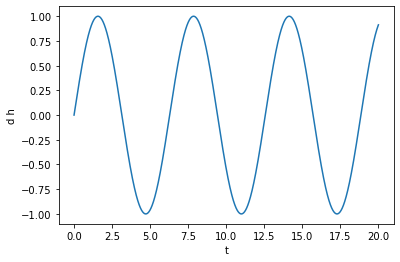

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

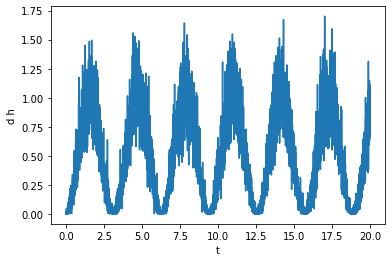

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

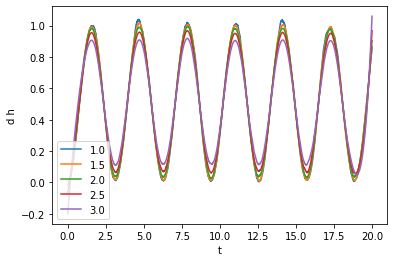

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

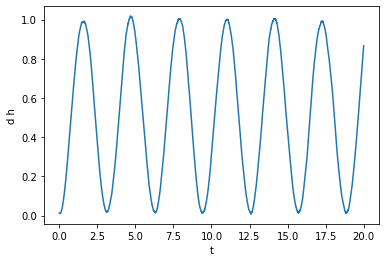

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.2061


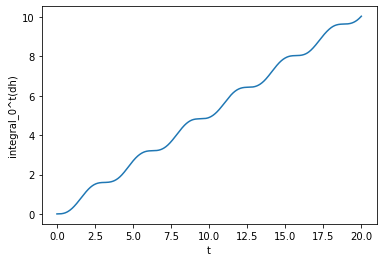

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

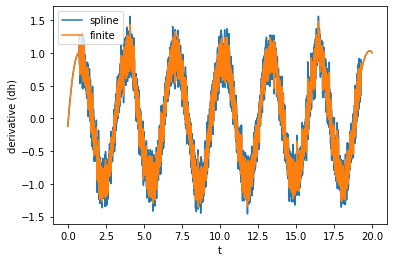

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

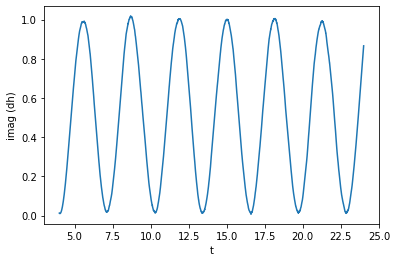

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

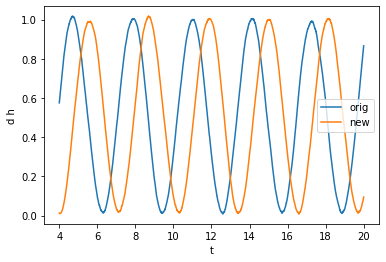

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

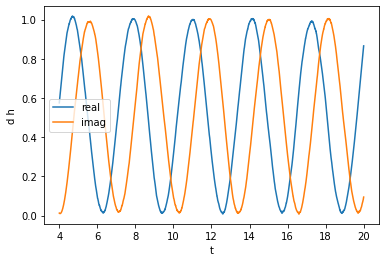

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

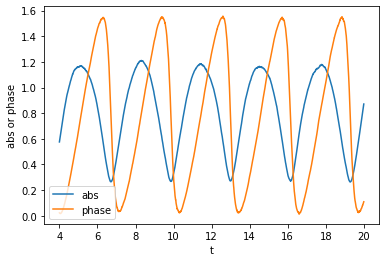

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

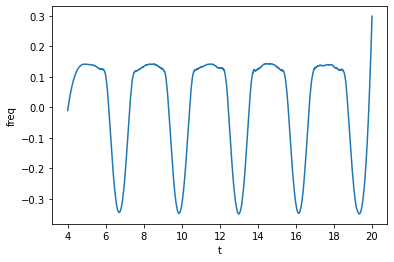

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

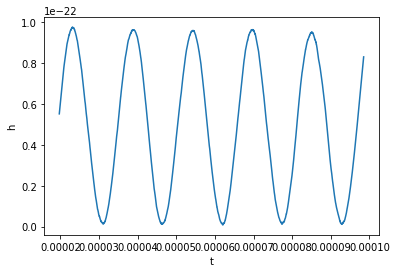

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

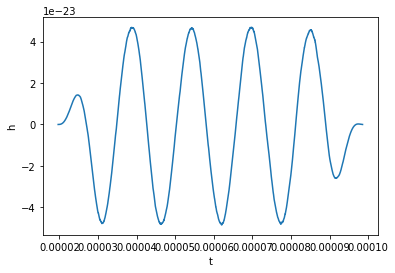

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

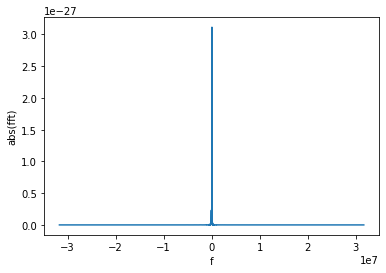

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

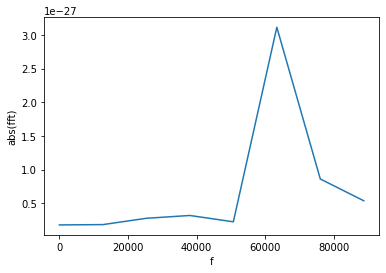

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64216.65


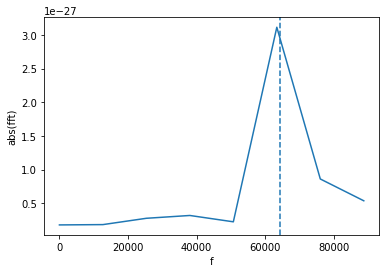

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.113e-27
Maximum with mask 8.604e-28
Length with mask 8
Length after having removed the masked points 7
